<center><h2>Isolation Forest</h2>From scratch</center>

#### Libraries

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pprint import pprint
import seaborn as sns
import pdb
sns.set_style(style="whitegrid")



## Sample data

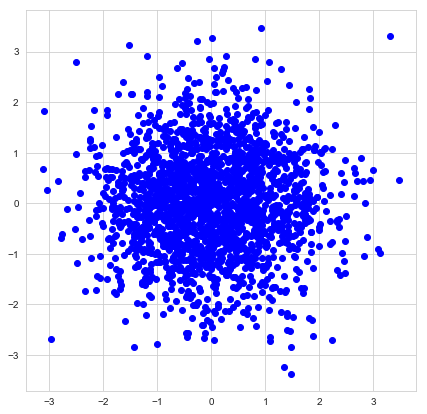

In [3]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 2000
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T
X = pd.DataFrame(X,columns=['feat1','feat2'])
plt.figure(figsize=(7,7))
plt.plot(x,y,'bo');

## Isolation tree
 1. Get sample of data
 2. Randomly select dimension
 3. Randomly pick a value in the dimension
 4. Split the data


<img src="images/tree_pseudo.png" alt="Drawing" style="width: 400px;"/>

In [4]:
b=4
b<=3

False

### Sample the data

In [5]:
def select_point(data):
    n_samples,n_columns = data.shape
    return data.iloc[random.choice(list(range(n_samples)))]

In [6]:
select_point(X)

feat1   -0.009301
feat2    0.636746
Name: 1124, dtype: float64

### Select a dimension

In [7]:
def select_feature(data): 
    return random.choice(data.columns)

### Select a value in the dimension

In [8]:
def select_value(data,feat):
    mini = data[feat].min()
    maxi = data[feat].max()
    return (maxi-mini)*np.random.random()+mini
    

In [9]:
select_value(X,select_feature(X))

2.416717603798817

### Split Data

In [10]:
def split_data(data, split_column, split_value):

    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] >  split_value]
    
    return data_below, data_above

In [11]:
a,b =split_data(X,
           select_feature(X),
          select_value(X,select_feature(X)))

### Isolation Tree

In [12]:
X

,feat1,feat2
0,3.300000,3.300000
1,0.741128,-0.365793
2,0.815561,-1.087631
3,0.691110,1.301502
4,0.340905,-0.057931
...,...,...
1995,-0.585715,1.101797
1996,1.734285,-0.324772
1997,-0.972723,0.430621
1998,0.349796,-0.838875


In [13]:
def classify_data(data):
    
    label_column = data.values[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [14]:
classify_data(X)

-3.3668611359280263

In [184]:
def isolation_tree(df,counter=0, max_depth=50,random_subspace=False):
        # data preparations
    if counter == 0:
        global COLUMN_HEADERS   
        COLUMN_HEADERS = df.columns
        data = df
        
        global counter_hist
        
        global instance
        instance = select_point(data)
   
    else:
        data = df
       

    
    if (counter == max_depth) or data.shape[0]<=1:
        classification = classify_data(data)

        return classification
    
    else:
        # Counter
        counter +=1
        
        # Select feature
        split_column = select_feature(data)
        
        # Select value
        split_value = select_value(data,split_column)


        # Split data
        data_below, data_above = split_data(data,split_column,split_value)
        
        
        
        # instantiate sub-tree      
        question = "{} <= {}".format(split_column, split_value)
        sub_tree = {question: []}
        
         # find answers (recursion)
        yes_answer = isolation_tree(data_below, counter,max_depth=max_depth)
        no_answer = isolation_tree(data_above, counter,max_depth=max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base cases).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree
    
    
        
    

In [185]:
tree = isolation_tree(X.head(6), max_depth=1)
pprint(tree)

{'feat2 <= -0.3112805917592687': [-1.087630779926135, -0.05793117124449048]}


# Forest

 1. For each tree
 2. Sample Data
 3. Fit tree

<img src="images/forest_pseudo.png" alt="Drawing" style="width: 400px;"/>

In [186]:
def isolation_forest(df,n_trees=5, max_depth=5, subspace=1):
    forest = []

    for i in range(n_trees):
        # Sample the subspace
        df = df.sample(frac=subspace)

        # Fit tree
        tree = isolation_tree(df,max_depth=max_depth)
        
        # Save tree to forest
        forest.append(tree)
    
    return forest
        
        

In [187]:
isolation_forest(X);


## Path Length

<img src="images/path_pseudo.png" alt="Drawing" style="width: 400px;"/>

In [287]:
def pathLength(example,iTree,path=0,trace=False):
    path=path+1
    question = list(iTree.keys())[0]
    feature_name, comparison_operator, value = question.split()
    
    # ask question
    if example[feature_name].values <= float(value):
        
        if trace:
            pdb.set_trace()
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]
        
        
    # base case
    if not isinstance(answer, dict):
        return path
    
    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree,path=path)
    
    
    
    
    
    return path

In [297]:
tree = isolation_tree(X.head(50),max_depth=50)

In [303]:
ins = X.sample(1)
pathLength(ins,tree,trace=False)

6

In [ ]:
def c_factor(n) :
    """
    Average path length of unsuccesful search in a binary search tree given n points
    
    Parameters
    ----------
    n : int
        Number of data points for the BST.
    Returns
    -------
    float
        Average path length of unsuccesful search in a BST
        
    """
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))